<a href="https://colab.research.google.com/github/willianrocha/bootcamp-datascience-alura/blob/main/module_5/ds_mod5_lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

dados = pd.read_excel('https://github.com/willianrocha/bootcamp-datascience-alura/blob/main/files/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
# dados_limpos.describe()
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

np.random.seed(73246)


x_columns = dados_limpos.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [ ]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

## Matriz de Confusão

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train, y_train)
predicao_arvore = modelo_arvore.predict(x_test)
accuracy_score(y_test, predicao_arvore)

0.6590909090909091

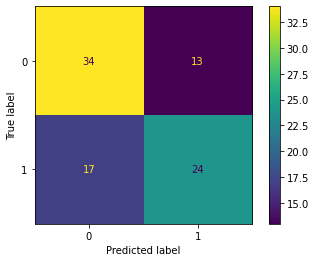

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(modelo_arvore, x_test, y_test)

In [ ]:
VP = 24
VN = 34
FP = 13
FN = 17

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicao_arvore))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



In [ ]:
VP / (VP+FP)

0.6486486486486487

In [ ]:
p = 1.0
r = 0.3
f1 = 2*(p*r)/(p+r)
print(f1)

0.4615384615384615


In [ ]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71        47
           1       0.68      0.61      0.64        41

    accuracy                           0.68        88
   macro avg       0.68      0.68      0.68        88
weighted avg       0.68      0.68      0.68        88



Precision: Todas as minhas classificações positivas, quantas são realmente positivas

Recall: Todas as classes positivas, quantas realmente foram classificadas corretamente

## ROC e AUC

In [ ]:
from sklearn.metrics import roc_auc_score

prob_arvore = modelo_arvore.predict_proba(x_test)
auc = roc_auc_score(y_test, prob_arvore[:,1])
auc

0.6453035806953815

In [ ]:
def roda_modelo(modelo, dados):
  np.random.seed(73246)
  x_columns = dados.columns
  y = dados['ICU']
  x = dados[x_columns].drop(['ICU', 'WINDOW'], axis=1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  modelo.fit(x_train, y_train)
  predicao = modelo.predict(x_test)
  prob_predict = modelo.predict_proba(x_test)
  
  auc = roc_auc_score(y_test, prob_predict[:,1])
  print(f'AUC: {auc}')
  print('\nClassification Report')
  print(classification_report(y_test, predicao))

roda_modelo(modelo_arvore, dados_limpos)

AUC: 0.6453035806953815

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.68      0.67        47
           1       0.62      0.61      0.62        41

    accuracy                           0.65        88
   macro avg       0.65      0.65      0.65        88
weighted avg       0.65      0.65      0.65        88



In [ ]:
roda_modelo(modelo, dados_limpos)

AUC: 0.7187337830825118

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.74      0.71        47
           1       0.68      0.61      0.64        41

    accuracy                           0.68        88
   macro avg       0.68      0.68      0.68        88
weighted avg       0.68      0.68      0.68        88



# Desafios

Desafio 02: Verificar o impacto da mudança nos resultados.

Desafio 03: Pesquisar sobre F-score.

## Desafio 04: Pesquisar e plotar a arvore de decisão criada pelo modelo.

https://mljar.com/blog/visualize-decision-tree/

### Representação em Texto

In [ ]:
from sklearn import tree

In [ ]:
text_representation = tree.export_text(modelo_arvore)
print(text_representation)

|--- feature_2 <= 6.50
|   |--- feature_128 <= -0.57
|   |   |--- feature_55 <= -0.86
|   |   |   |--- feature_196 <= -0.29
|   |   |   |   |--- feature_202 <= -0.86
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_202 >  -0.86
|   |   |   |   |   |--- feature_71 <= -0.82
|   |   |   |   |   |   |--- feature_178 <= -0.77
|   |   |   |   |   |   |   |--- feature_223 <= -0.72
|   |   |   |   |   |   |   |   |--- feature_43 <= -0.87
|   |   |   |   |   |   |   |   |   |--- feature_131 <= -1.00
|   |   |   |   |   |   |   |   |   |   |--- feature_209 <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_209 >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_131 >  -1.00
|   |   |   |   |   |   |   |   |   |   |--- feature_189 <= -0.86
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |  

### Com matplotlib

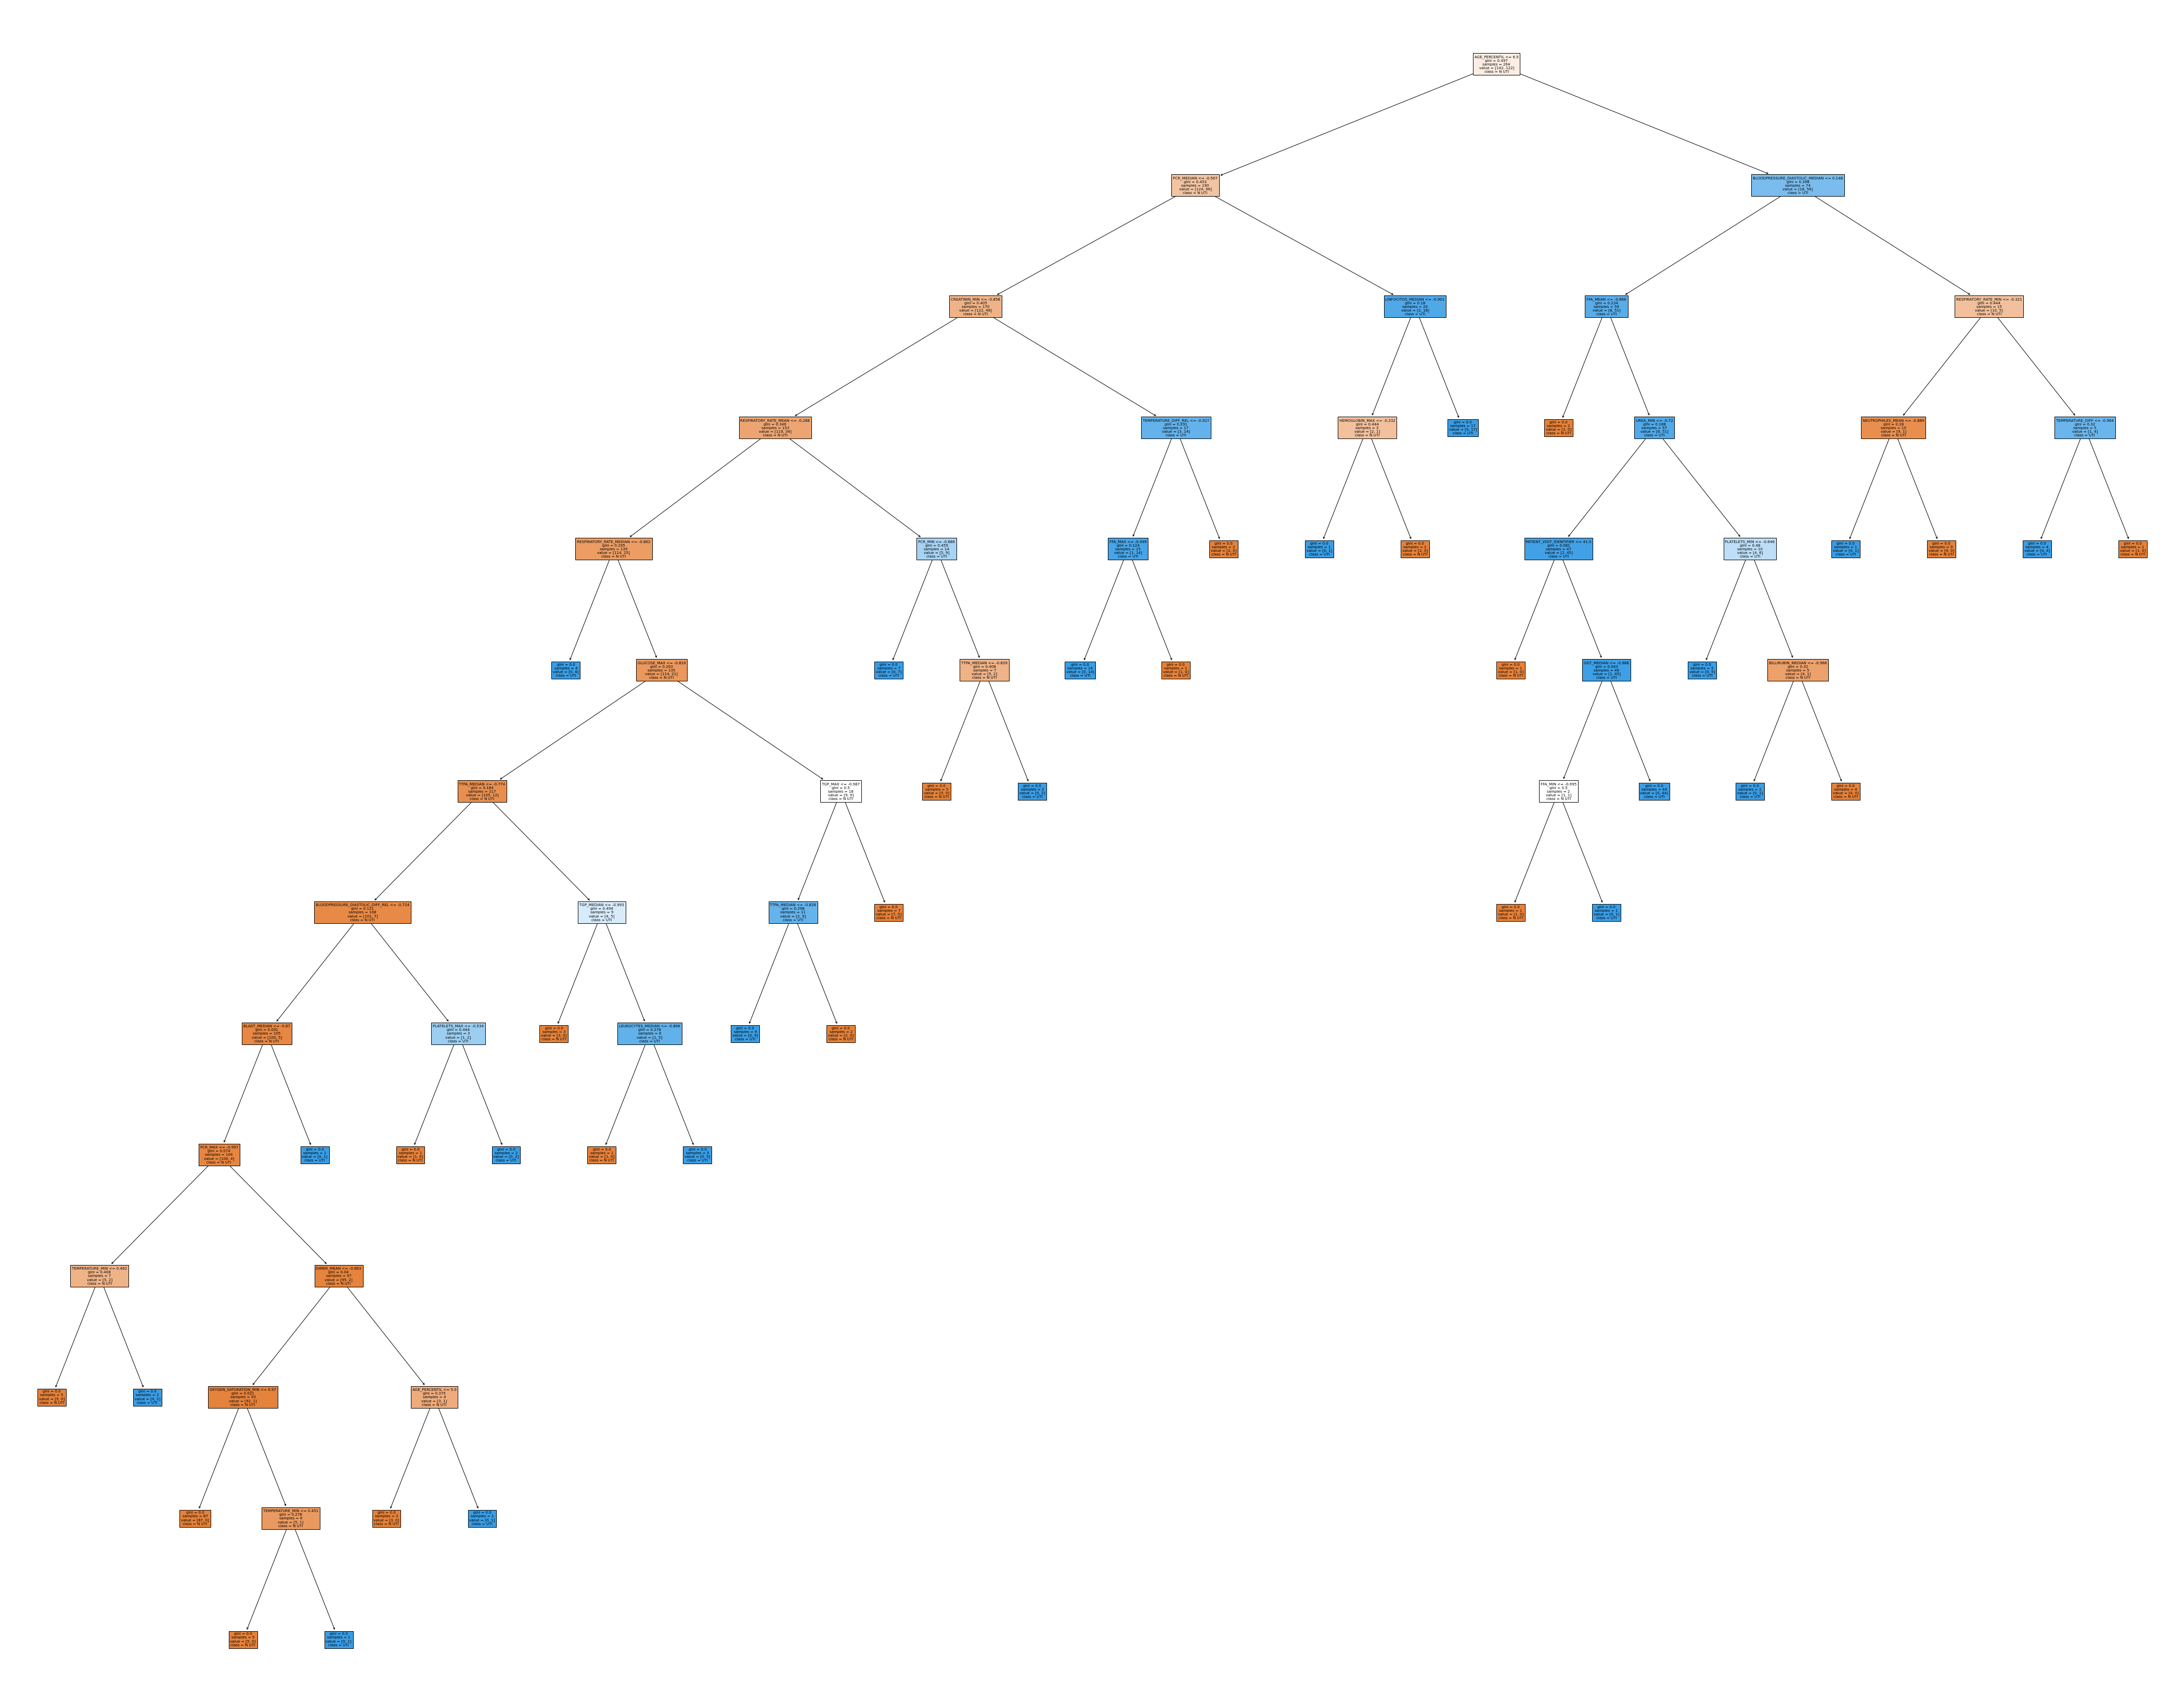

In [ ]:
fig = plt.figure(figsize=(75,60))
_ = tree.plot_tree(modelo_arvore, 
                   feature_names=x.columns,  
                   class_names=["N UTI", "UTI"],
                   filled=True)
fig.savefig("decistion_tree.png")

### Com graphviz

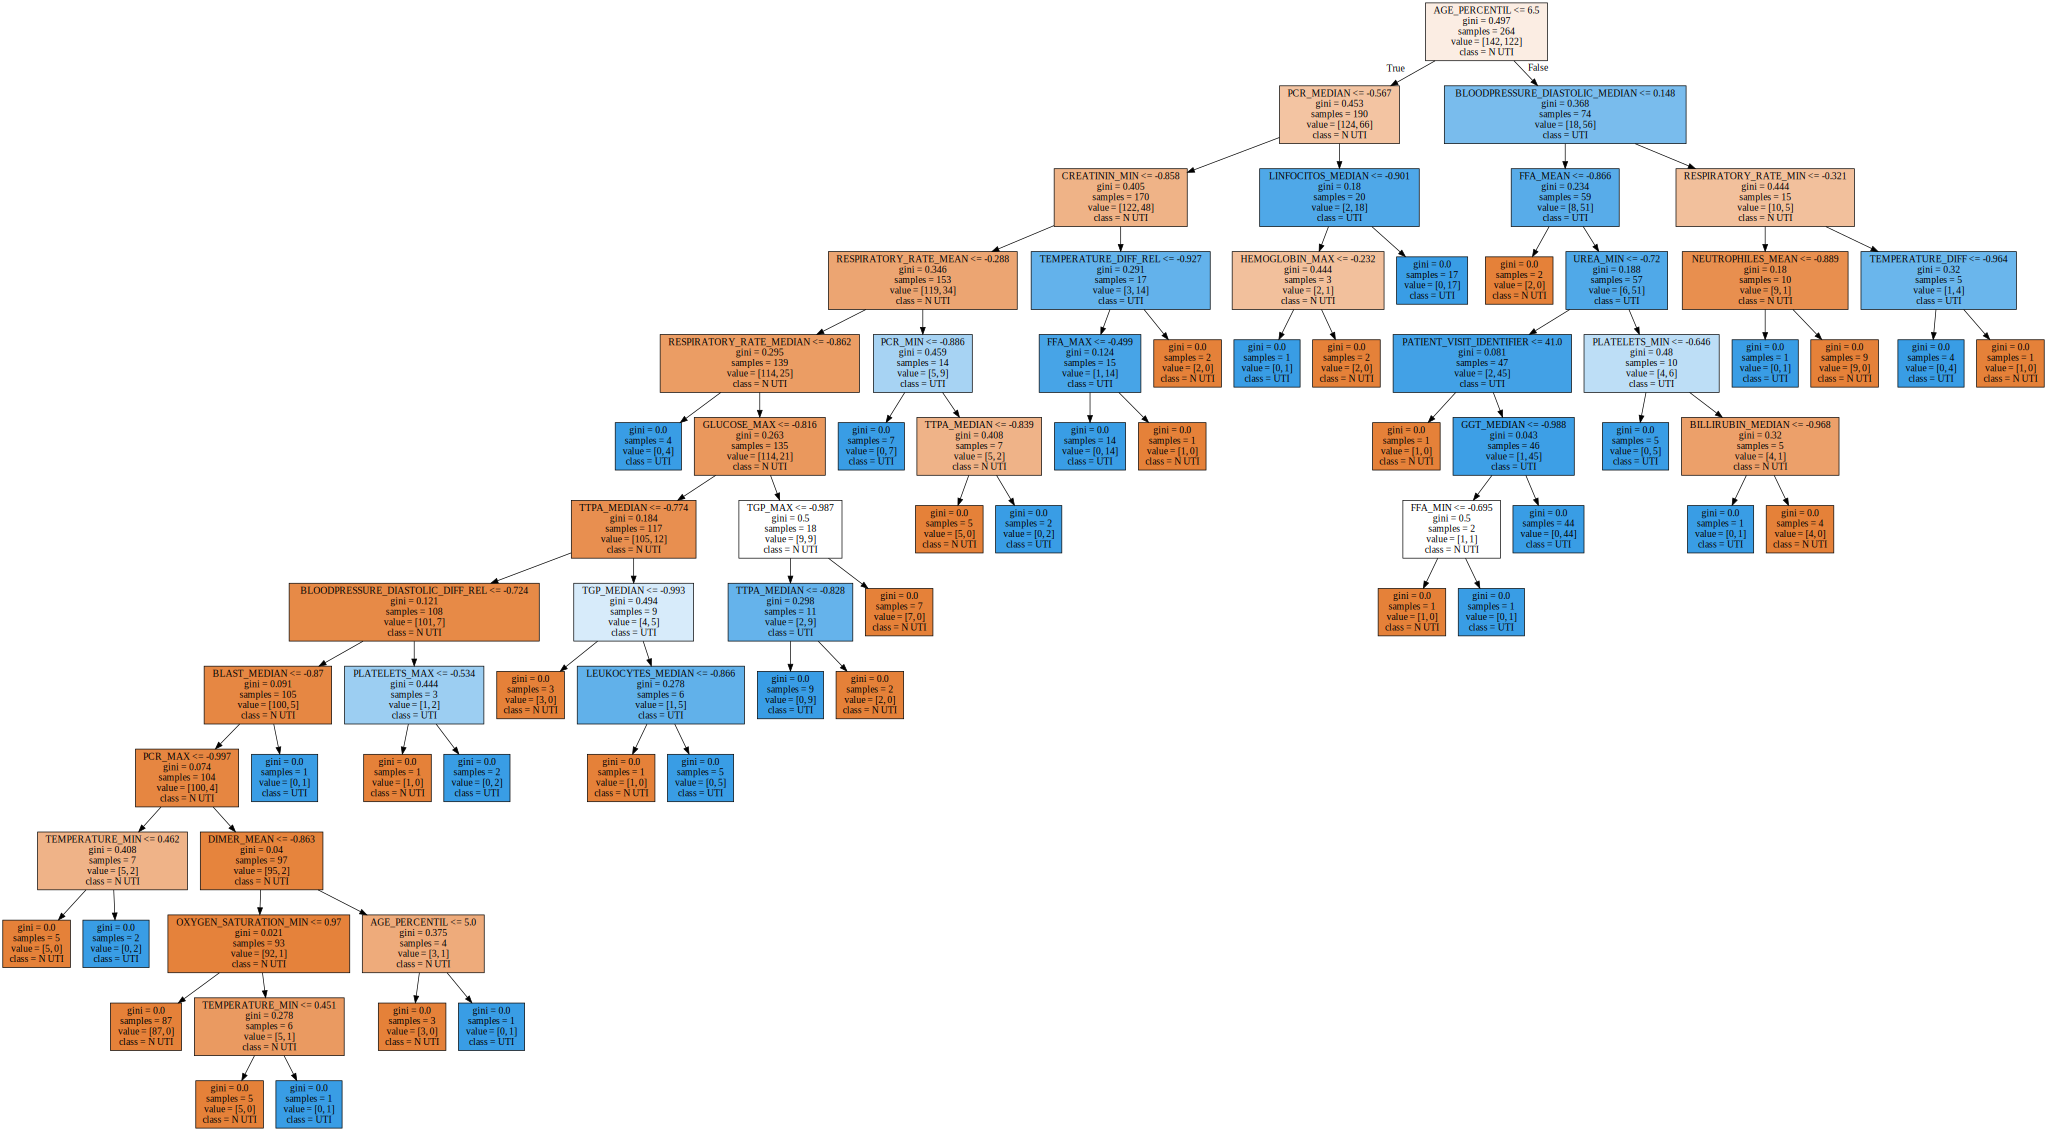

In [ ]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(modelo_arvore,
                                feature_names=x.columns,
                                class_names=["N UTI", "UTI"],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph

### Usando dtreeviz

In [ ]:
!pip install dtreeviz

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


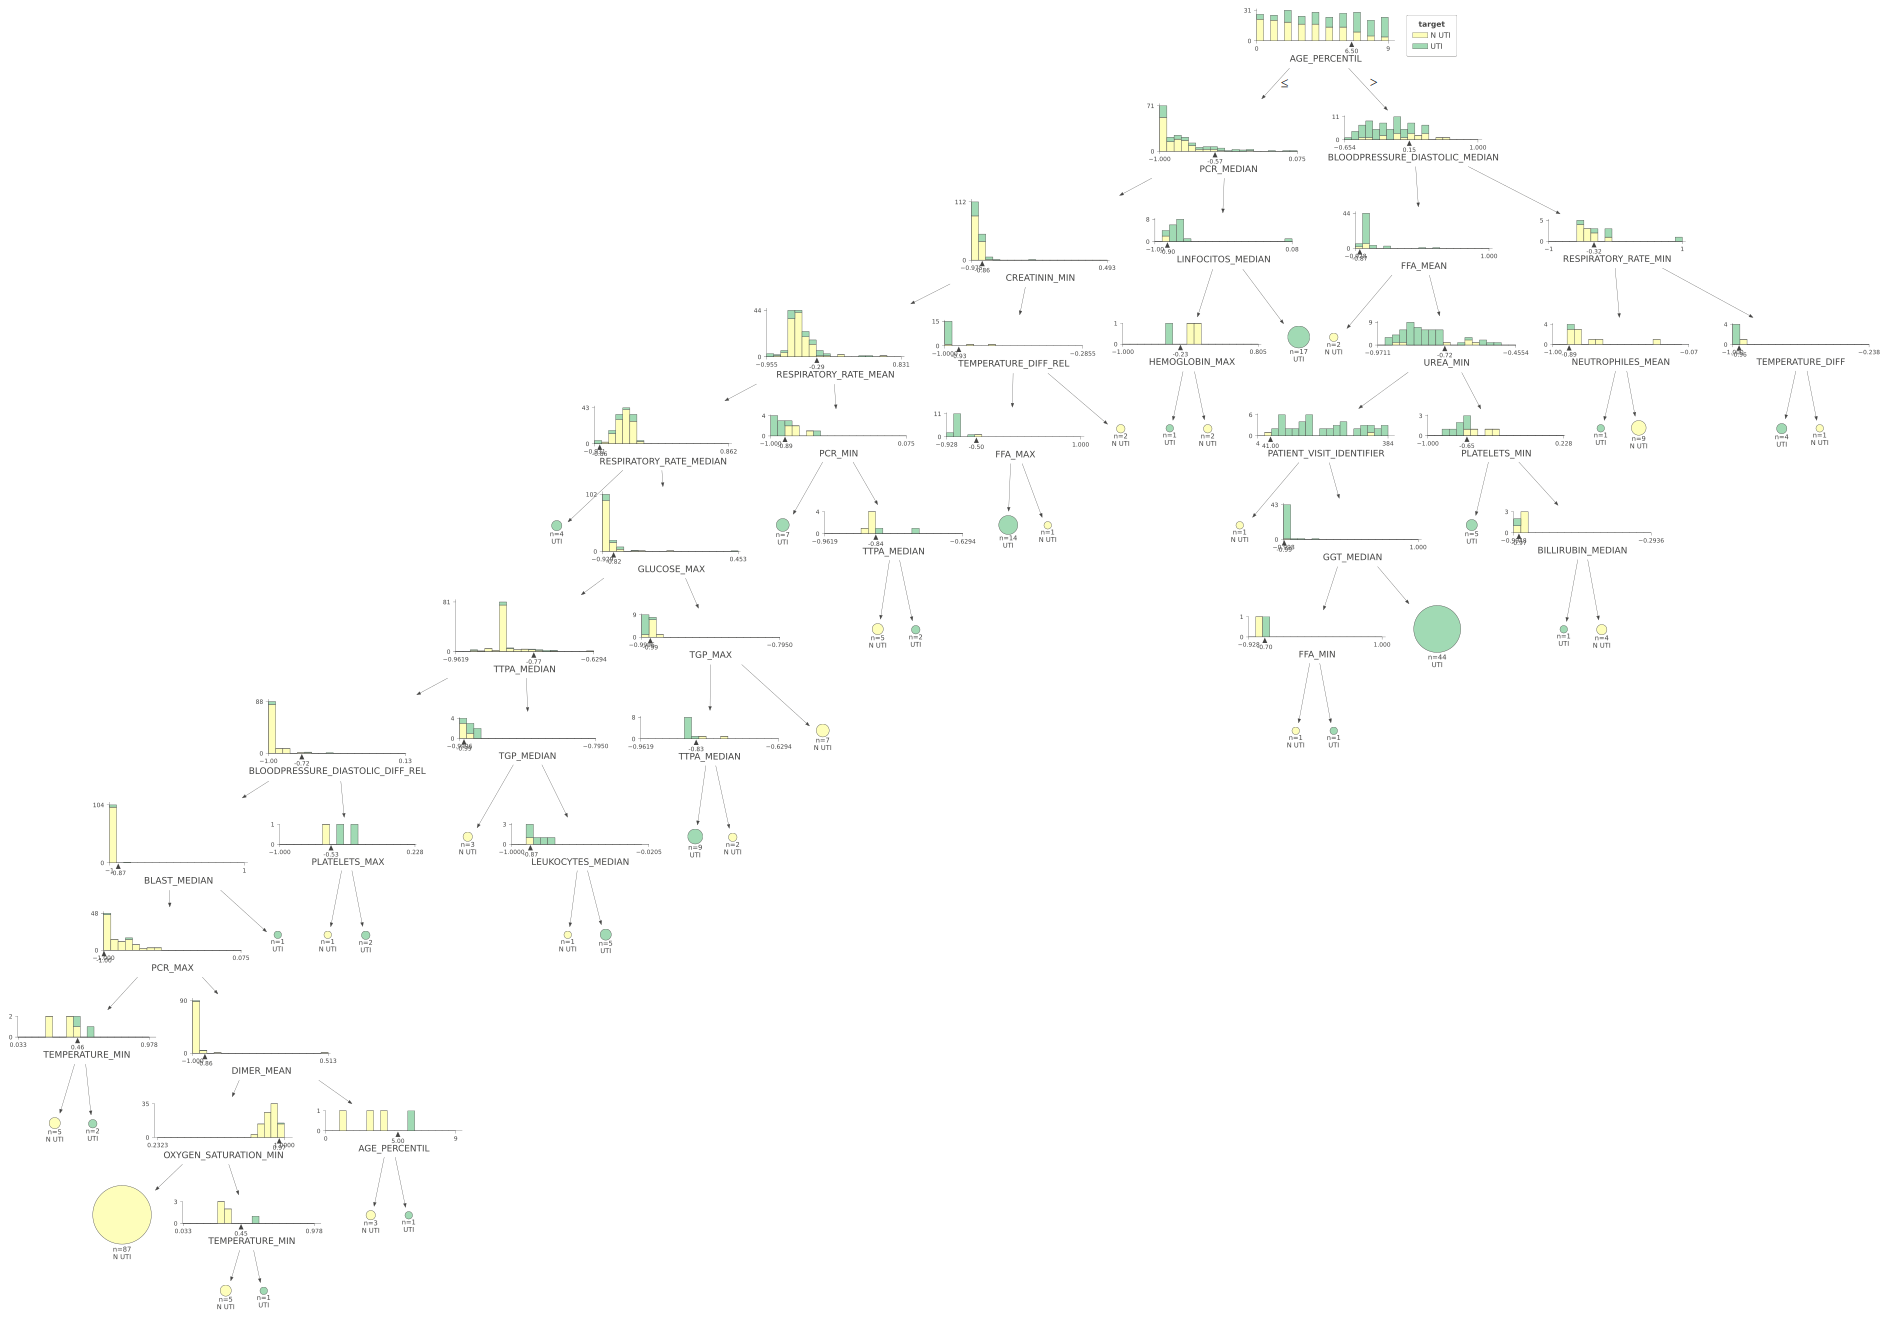

In [ ]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(modelo_arvore, x_train, y_train,
                target_name="target",
                feature_names=x.columns,
                class_names=["N UTI", "UTI"]
               )

viz

## Desafio 05: Criar uma função que gere a curva ROC.

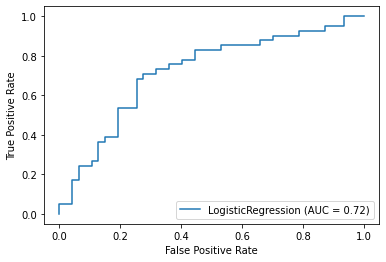

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(modelo, x_test, y_test)

In [ ]:
# prob_arvore
proba = modelo.predict_proba(x_test)
df = pd.DataFrame(proba)
df['y'] = y_test.reset_index()['ICU']
# df = df.sort_values(by=[1]).reset_index(drop=True)
# df.plot(kind='line', x=1, y=0)
df

,0,1,y
0,0.519814,0.480186,1
1,0.456220,0.543780,1
2,0.858580,0.141420,0
3,0.777880,0.222120,0
4,0.908248,0.091752,0
...,...,...,...
83,0.729448,0.270552,0
84,0.691035,0.308965,1
85,0.695885,0.304115,0
86,0.249558,0.750442,0


## Desafio 06: Pensar e tentar diminuir o efeito de aleatoriedade nas previsões.

Fixar seed dentro da função